# Bajaj Finance

In [1]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 900
png_renderer.height = 500
pio.renderers.default = "png"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/nbfc/bajaj_finance/bajaj_finance.csv')

In [3]:
# Company username
company_username = 'Bajaj_Finance'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [9]:
qdf.shape

(22528, 28)

In [10]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 17499


In [11]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [12]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [13]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

0it [00:00, ?it/s]

In [14]:
result.head()

,conversation_id,response_time
0,1344317386132844545,0.000000
1,1343935142734123013,0.278611
2,1344311687264944128,0.000000
3,1344314012373188616,0.000000
4,1344286581432016896,1.002500


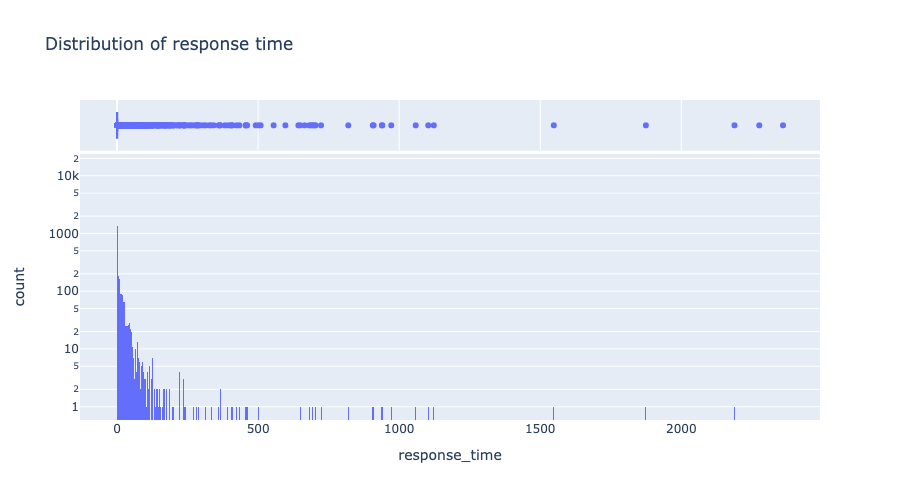

In [15]:
fig = px.histogram(result, x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [16]:
result['resolution_time'] = 0

In [17]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

0it [00:00, ?it/s]

In [18]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 9435
Number of queries unresolved: 8064


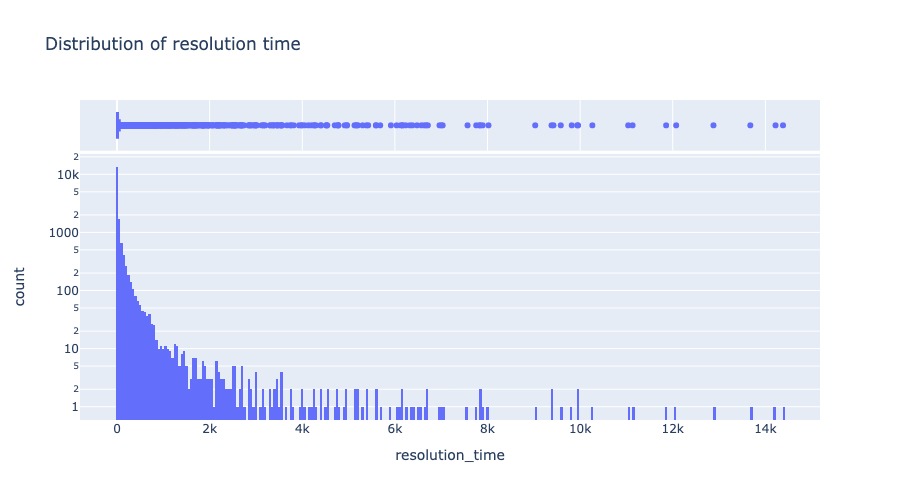

In [19]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

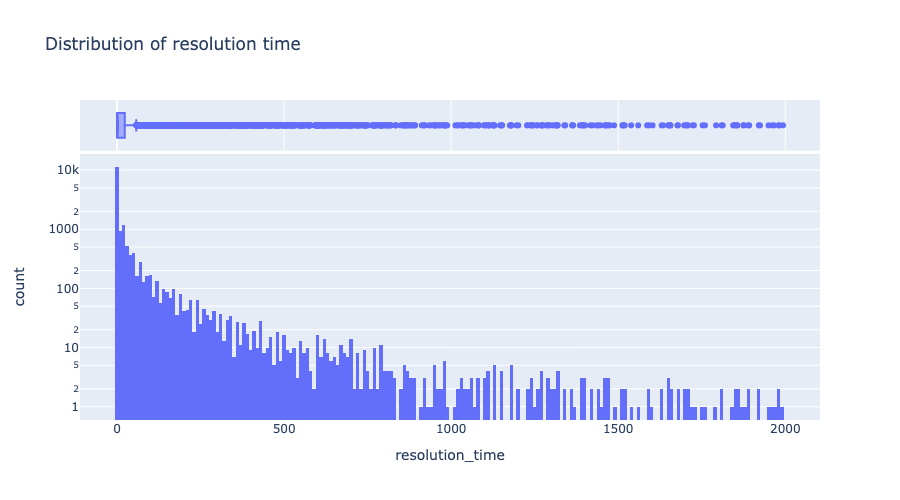

In [20]:
fig = px.histogram(result[result['resolution_time']<2000], x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [21]:
result.describe()

,response_time,resolution_time
count,17499.000000,17499.000000
mean,5.613538,89.285324
std,49.460617,521.301510
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.311944
75%,0.536944,23.821528
max,2360.426389,14380.907222


## Query Tweets Topics


In [22]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]
queries.shape


(5911, 28)

In [23]:
processor = Processor('./../../data/config.json')
pre_queries, post_queries = processor.preprocess(queries)
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]


In [24]:
pre_queries.shape


(2218, 31)

In [25]:
post_queries.shape


(3118, 31)

In [26]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.6,
                                        eta=0.3)
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)

Pre-COVID coherence Score:  -3.447095072299471


In [27]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.153722 -0.024102       1        1  30.469182
1      0.002383  0.079749       2        1  24.473231
0     -0.073736 -0.123790       3        1  22.907657
3     -0.082369  0.068143       4        1  22.149930, topic_info=         Term        Freq       Total Category  logprob  loglift
30      calls  285.000000  285.000000  Default  30.0000  30.0000
311   calling  158.000000  158.000000  Default  29.0000  29.0000
64    account  160.000000  160.000000  Default  28.0000  28.0000
104  deducted   56.000000   56.000000  Default  27.0000  27.0000
144  emi_card  101.000000  101.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
164   details   24.888947   67.456879   Topic4  -5.5444   0.5103
302   company   27.951017  109.705442   Topic4  -5.4284   0.1400
127      bank   24.060884   68.854802   Topic4  -5.5783   0.4559
27       time   23.573782  144.933126   Topic4  -5.5987  -0.3088
121      guys   23.399703  162.577270   Topic4  -5.6061  -0.4311

[305 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4860      1  0.890031  abhinav
663       1  0.065478  abusing
663       2  0.851215  abusing
125       2  0.027404       ac
125       3  0.931740       ac
...     ...       ...      ...
282       2  0.901353  written
282       4  0.090135  written
1041      1  0.935631     year
1041      3  0.040680     year
1041      4  0.040680     year

[590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [28]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())


In [29]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['loan, days, today, guys, times, card, got, payment, response, calls',
       'calls, loan, calling, people, day, getting, stop, guys, stop_calling, number',
       'emi, customer_care, loan, deducted, charges, customers, ur, account, request, contact',
       'account, loan, number, emi_card, emi, help, kindly, pay, customer, money'],
      dtype=object)

Following topics were discussed in Pre-COVID period:
1. Loan related queries
2. Unnecessary calls from the company
3. Issues with automatic EMI deductions
4. Issues with EMI card

In [30]:
# select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
# pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



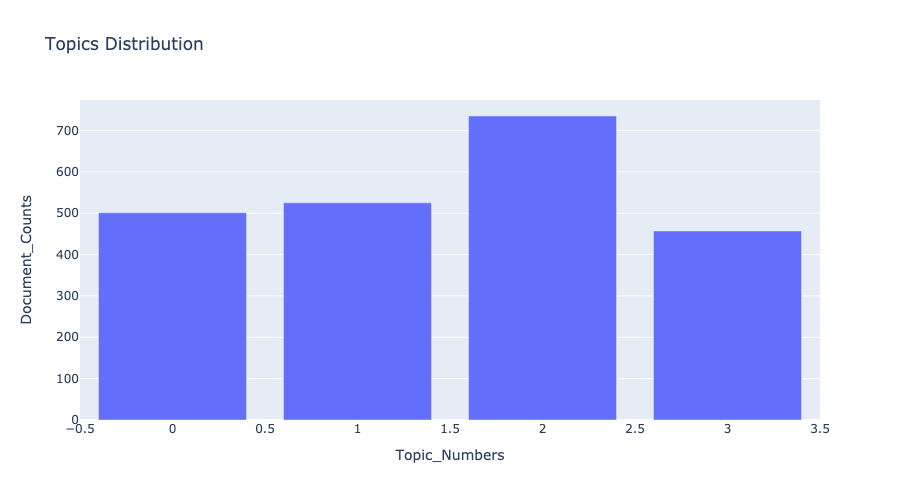

In [31]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()


In [32]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)


Post-COVID coherence Score:  -2.9164698124839266


In [33]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.063932  0.089506       1        1  37.937954
0     -0.128445 -0.000270       2        1  33.206219
2      0.064513 -0.089236       3        1  28.855827, topic_info=         Term        Freq       Total Category  logprob  loglift
54        emi  681.000000  681.000000  Default  30.0000  30.0000
1       calls  167.000000  167.000000  Default  29.0000  29.0000
21       paid  148.000000  148.000000  Default  28.0000  28.0000
147  customer  197.000000  197.000000  Default  27.0000  27.0000
134   charges  130.000000  130.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
235      need   40.128202  158.634276   Topic3  -5.6693  -0.1317
10       stop   37.160961  113.880197   Topic3  -5.7461   0.1230
40       want   37.267352  132.338404   Topic3  -5.7433  -0.0244
118   payment   36.910968  174.906442   Topic3  -5.7529  -0.3129
267  received   34.071451  142.557041   Topic3  -5.8329  -0.1884

[255 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
782       2  0.944221     absolutely
1229      1  0.773736             ac
1229      2  0.037743             ac
1229      3  0.188716             ac
2592      1  0.920422         accept
...     ...       ...            ...
899       1  0.962300        website
899       3  0.026731        website
1118      1  0.178697  worst_service
1118      2  0.044674  worst_service
1118      3  0.804135  worst_service

[395 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [34]:
post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())


In [35]:
post_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['loan, calls, number, dont, team, company, time, getting, help, need',
       'emi, customer, loan, month, paid, time, card, pay, emi_card, request',
       'emi, loan, moratorium, account, pay, payment, month, card, charges, finserv'],
      dtype=object)

Following topics were discussed in the Post-COVID period:
1. Unnecessary calls from the company
2. EMI card and moratorium
3. Loan EMI and moratorium

In [36]:
# select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[2]
# post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



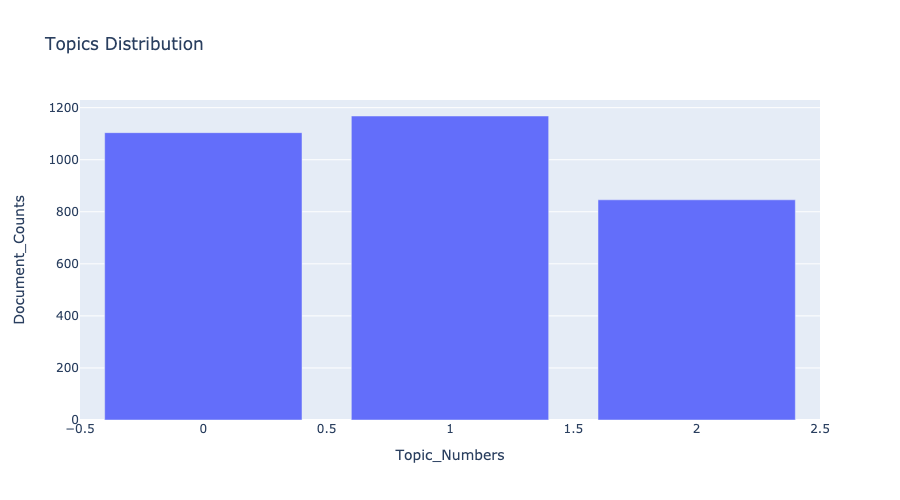

In [37]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()

In [38]:
pre_queries_dist

,Topic_Numbers,Document_Counts
0,2,735
1,1,525
2,0,501
3,3,457


In [39]:
post_queries_dist

,Topic_Numbers,Document_Counts
0,1,1168
1,0,1104
2,2,846
